# This is the tutorial for polyribosomes tracking.
Before everthing goes, you need put the star files with ribosomes in the directory the same as this tutorial.
The step following:

In [22]:
#1. If you only want to do test, this section is aimed to generate simulation polysomes data
import os 
import numpy as np
from py_test.addRmPoly import setup
from py_test.addRmPoly import teardown
from polysome_class.polysome import Polysome
#delete old files
if os.path.exists('cluster-sim_drop/run0/allTransforms.star'):
    os.remove('cluster-sim_drop/run0/allTransforms.star')

if os.path.exists('cluster-sim_drop/run0/scores/tree.npy'):
    os.remove('cluster-sim_drop/run0/scores/tree.npy')
#generate simulation data, you will get three polys of 2 classes
#poly1: angle trans[30,10,70]; shift trans[20,40,50]; length:15  ==> 100.mrc
#poly2: angle trans[10,20,30]; shift trans[60,40,10]; length:30  ==>100.mrc
#poly3: angle trans[10,20,30]; shift trans[60,40,10]; length:25 ==>101.mc
#PS:you can also change the class of polys in ./py_test/addRmPoly.py

setup() #ATTENTION: remember to create py_test fold for this function

Generating simulation data.


In [23]:
# If you want to test the function of ribosomes filling up to linke short polys, just do following. It will delete
# one ribosome of poly1. You can also delete manualy in sim.star (the lat column of sim.star will tell you 
# which poly the ribosome belongs to)
from py_io.tom_starread import tom_starread
from py_io.tom_starwrite import tom_starwrite
simStar = tom_starread('./sim.star')
drop_index = 35
ribo_info = simStar.iloc[35,:]
print('drop the ribosome with euler angle:%.3f,%.3f,%.3f, and position:%.3f,%.3f,%.3f'%(ribo_info['rlnAngleRot'],
                                                                                       ribo_info['rlnAngleTilt'],
                                                                                       ribo_info['rlnAnglePsi'],
                                                                                       ribo_info['rlnCoordinateX'],
                                                                                       ribo_info['rlnCoordinateY'],
                                                                                       ribo_info['rlnCoordinateZ']))
simStar.drop(index = [drop_index],inplace = True)
header = { }
header["is_loop"] = 1
header["title"] = "data_"
header["fieldNames"]  = ["_%s"%i for i in simStar.columns]
tom_starwrite('./sim_drop.star', simStar, header)
#2. initialize the polysome class, what you need do is feeding the following command with input_star == ***.star
#   and the root directory: run_time = *** (default:run0)
polysome1 = Polysome(input_star = './sim_drop.star', run_time = 'run0')

drop the ribosome with euler angle:19.762,85.725,176.588, and position:1190.370,238.879,850.021


In [24]:
#3. modify the properties. Most properties are already initialized. What you should pay attention to is 
#   ==>clustThr: the threshold for clustering, higher clustThr, few clusters 
#   ==>relinkWithoutSmallClasses: if discard the classes that failed to form a cluster given the clustThr.
#      This is useful if you find the clustering results are poor. 
#   ==> miniNumTransforms: if keep the classes of transformation if the number of trans is smaller than this number, default is 0
polysome1.classify['clustThr'] = 5
polysome1.classify['relinkWithoutSmallClasses'] = 0
polysome1.sel[0]['minNumTransform'] = 0

In [25]:
#4. creat the outputfolder. By default, there will be one root directory named the same as the star file name
#   and other subdirectoris for data stored and figures for visulization.
polysome1.creatOutputFolder()

In [26]:
#5. calculating the transforms. Firstly, you should give two parameters:
#   5.1: the pixel size of your data used for this tutorial 
#   5.2: the distance(A) between two ribosomes which we think tend to close 
polysome1.transForm['pixS'] = 3.42 # in Ang
polysome1.transForm['maxDist'] = 342 # in Ang
polysome1.calcTransForms(worker_n = 2) #the number of CPUs to process the data(#cpu == #tomograms)

Using parallel cpus to calculate transformations.
Finish calulating transformations with 5.56266 seconds consumed.


In [28]:
#6. using hieachical clustering method to classify the trans.
#   For data normalization in classfication, there offers three methods: 'scale2Ang'/'scale2AngFudge'/'mean0+1std', default:scale2Ang
#   You can change it by:  polysome1.classify['cmb_metric'] = 'scale2Ang'
print(polysome1.transList.shape[0])#the total rows of the data needed to process
polysome1.groupTransForms(worker_n = 1) # if you have GPUs, can do: polysome1.groupTransForms(gpu_list = [1,2])

6137
Starting clustering
Free memory: 576416.53 mib
Using inverse transforms


In [40]:
#7. select the data. We can split the data into different subset according to your purpose for further analysis. 
#   We offered three methods: transform class/polysome label/# of transforms. Default is by transform classes.
transListSel, selFolds = polysome1.selectTransFormClasses()

In [29]:
#8. align the transforms. For each transforms, there are two different transformation(from ribosome A->B OR B->A)
#   We align the transformations of the same direction.
polysome1.alignTransforms()  

In [30]:
#9. track the polysomes in the same transform class and the same tomogram. This will give each transform with the polysome label
polysome1.find_connectedTransforms()

Summary polysomes


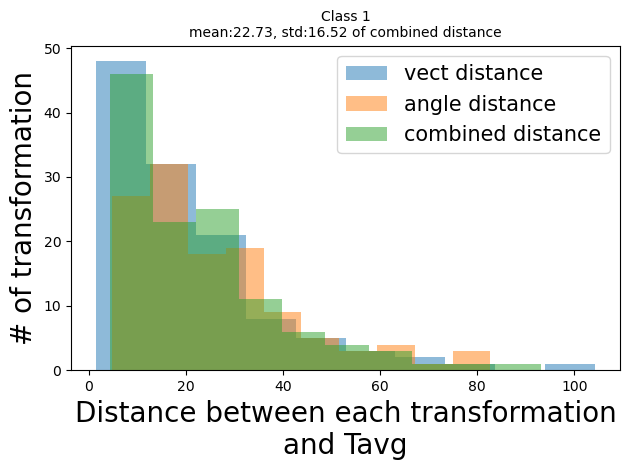

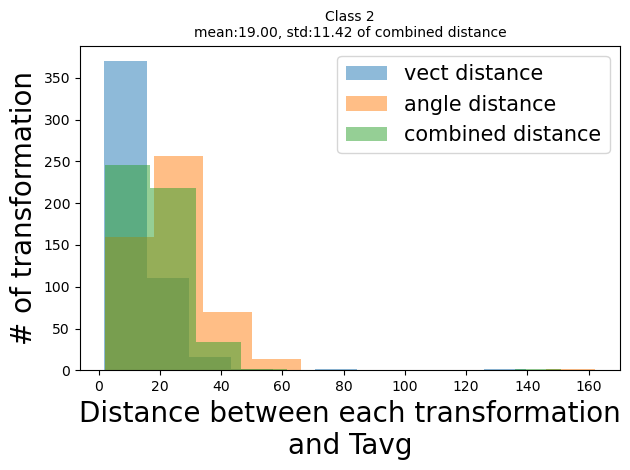

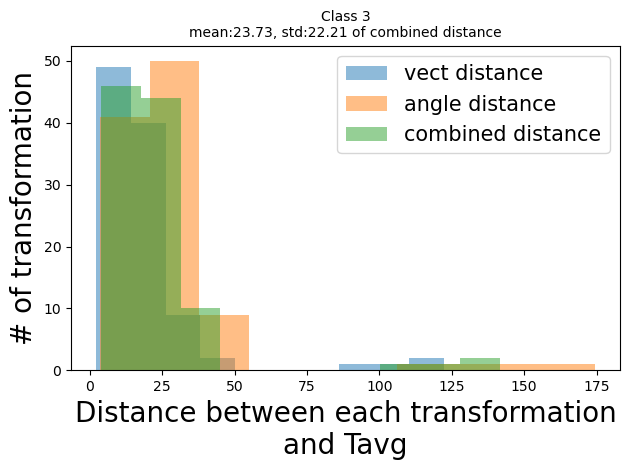

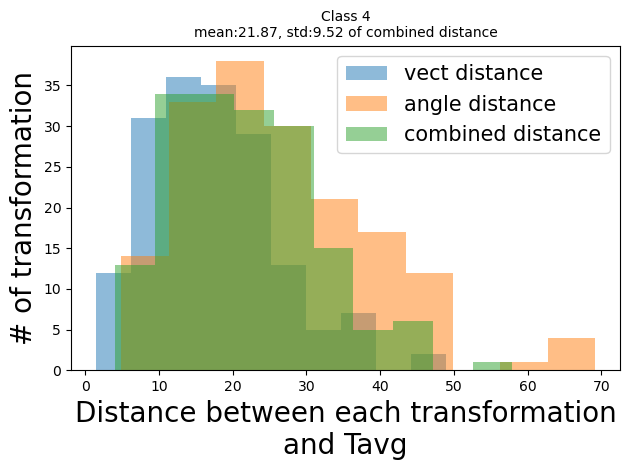

classNr	num	stdTransVect	stdTransAng	numPolybg5	numPolybg3	numPolyMax	numBranch		
2	501	12.0	13.9	4	11	19	1
1	121	19.3	17.2	4	7	14	1
4	170	9.6	12.7	0	0	1	0
3	104	22.4	25.5	0	0	2	0


In [6]:
#10. summary the tracking results. This step can generate two useful summary files in each transform class
#    10.1: statPerClass.star ==> the polysome information in each transform class
#    10.2: statPerPoly.star ==> the information for each polysome
#    Pay attention to if branches have been dected in polysomes
polysome1.analyseTransFromPopulation()

In [12]:
#10. analysis the pattern of ribosomes in each transform class/polysome (developing)
polysome1.analyseConfClasses()  #developing

In [13]:
#11. generating the information of ribosomes from the selection subset from step7
polysome1.genOutputList(transListSel, selFolds)

In [14]:
#12. averaging the ribosomes in each class transform (developing)
polysome1.generateTrClassAverages()
polysome1.genTrClassForwardModels()

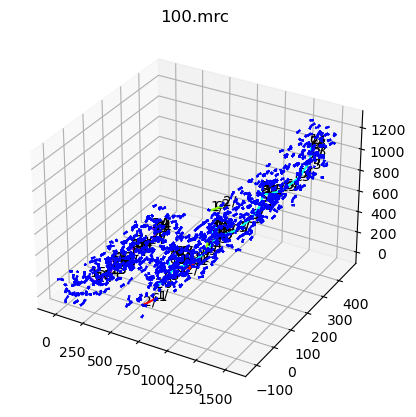

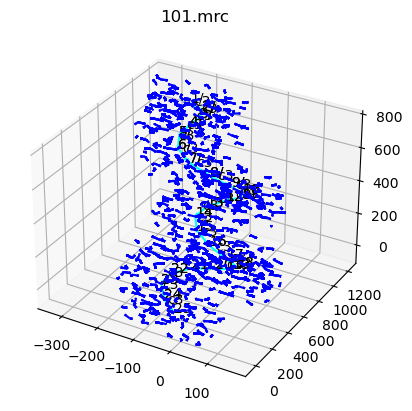

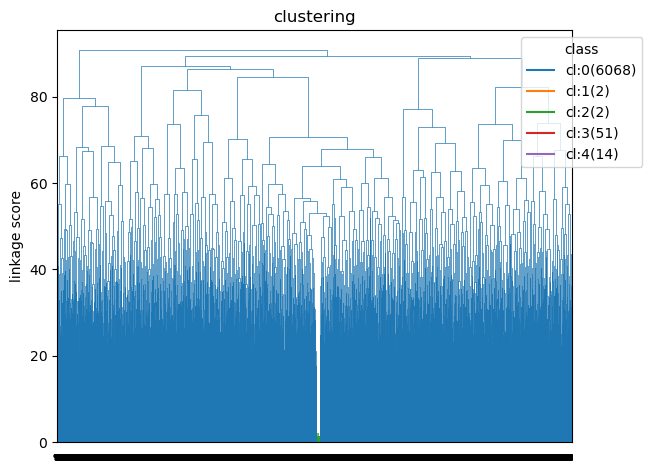

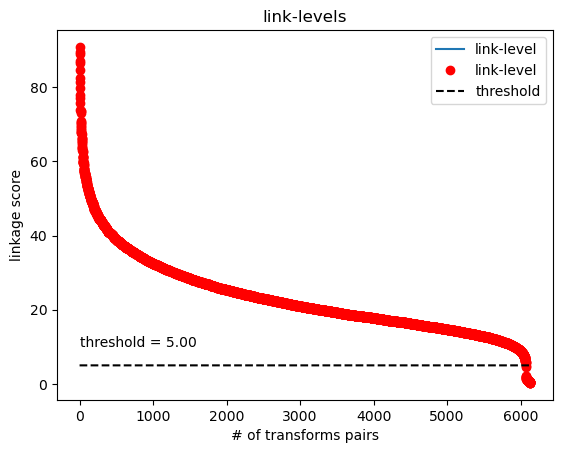

In [31]:
#13. generating figures for visilization, can skip this step if need
polysome1.visResult()

<IPython.core.display.Javascript object>


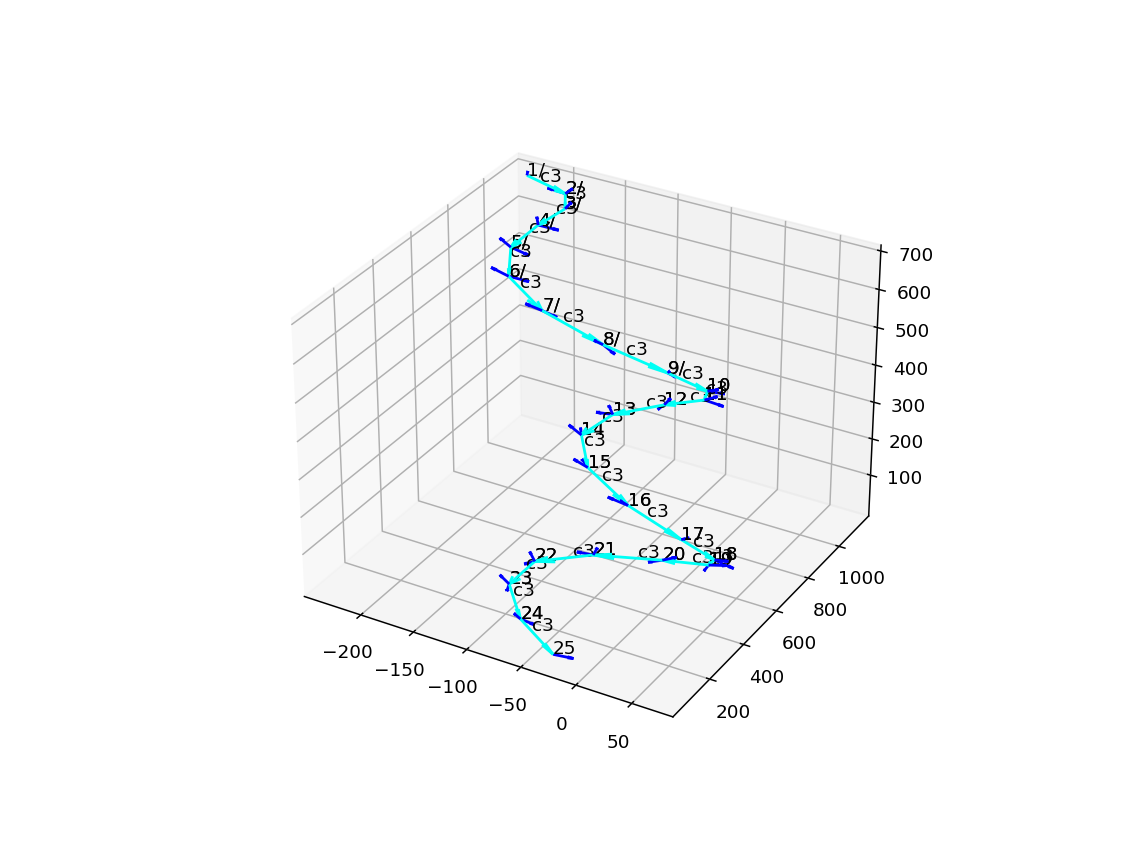

<IPython.core.display.Javascript object>


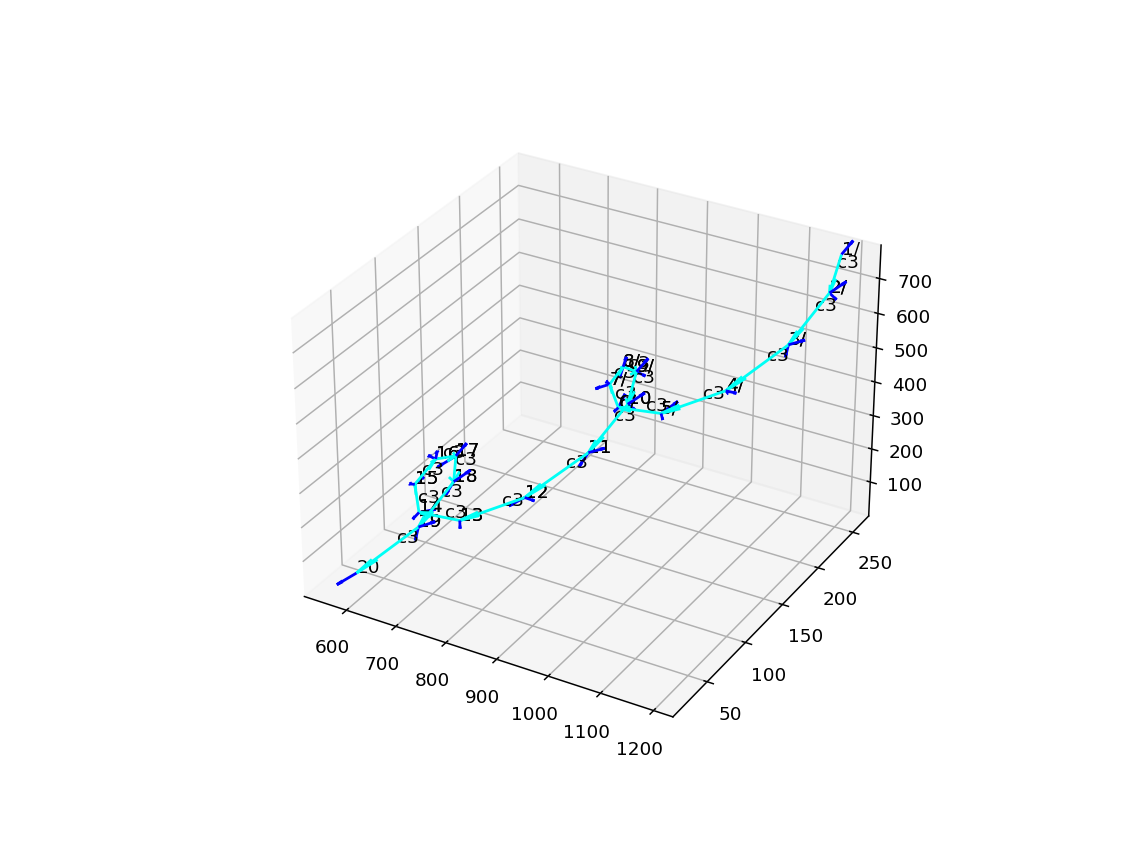

<IPython.core.display.Javascript object>


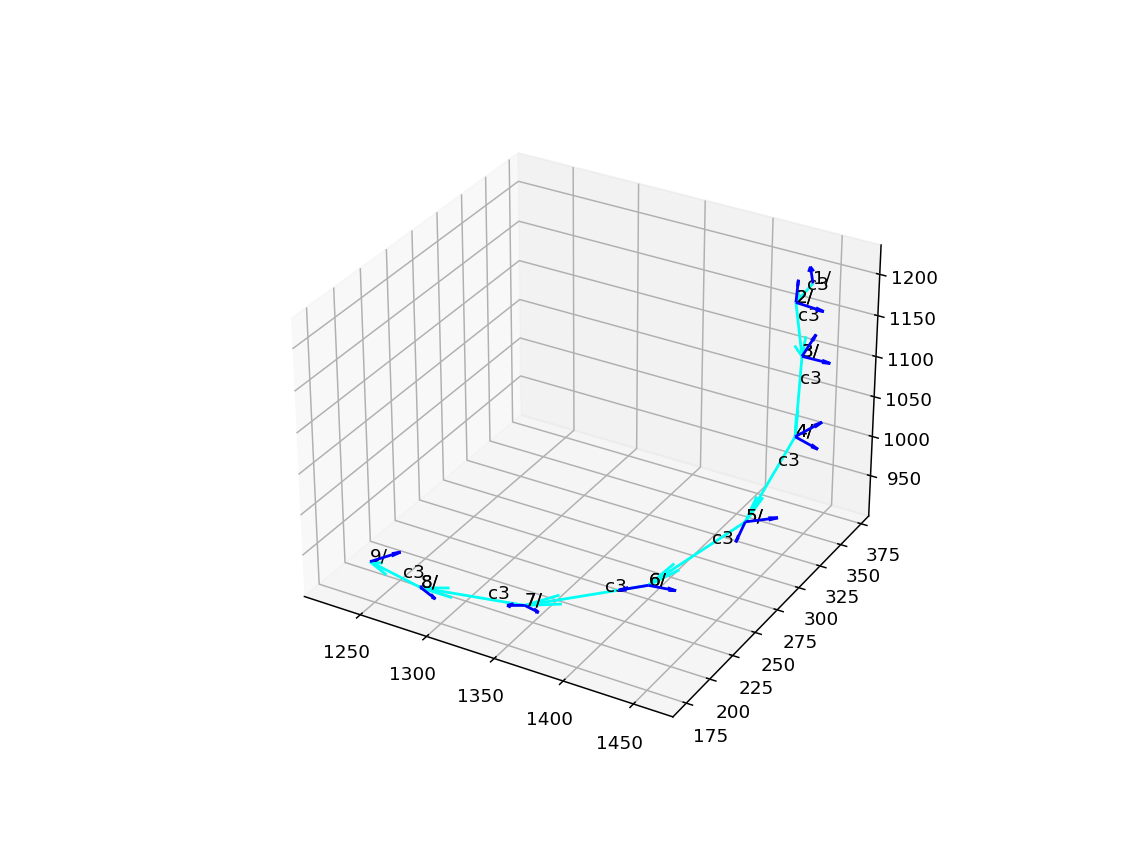

<IPython.core.display.Javascript object>


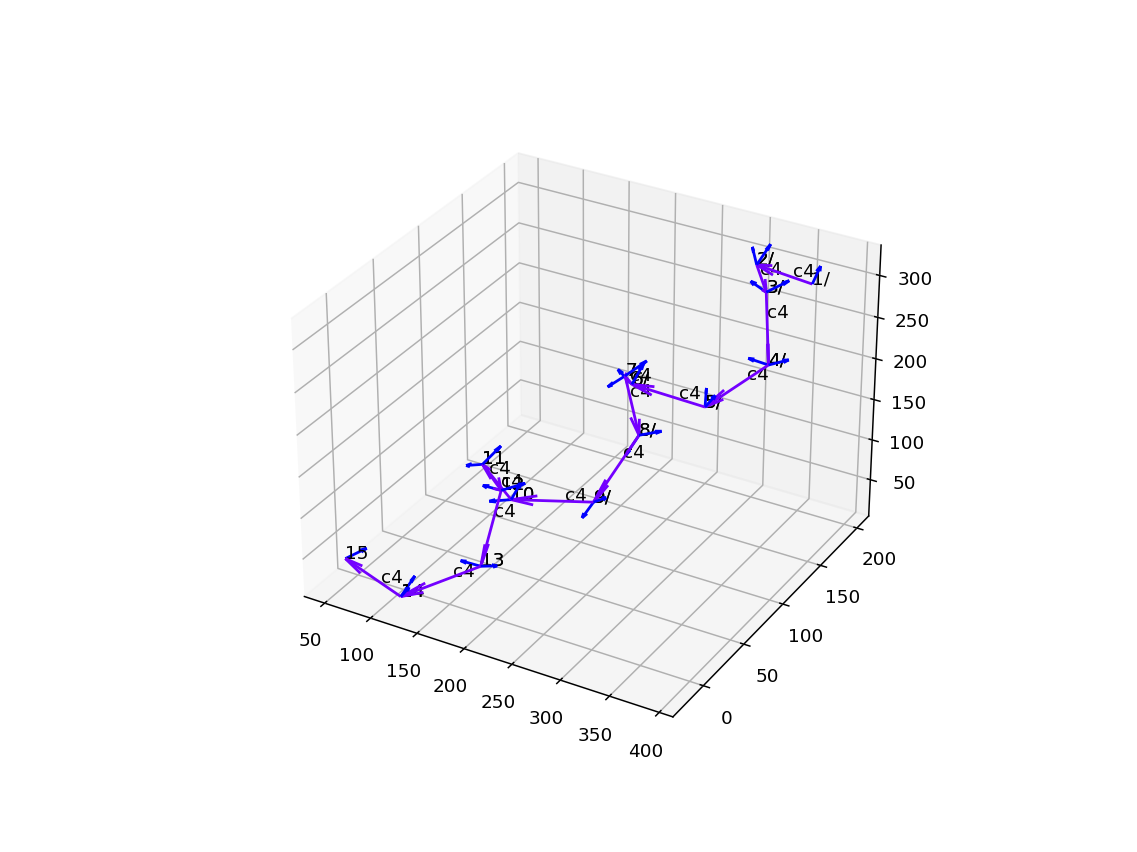

In [36]:
#13.1 onlys visilize long polysome
#for interactive play with the 3D figure
%matplotlib notebook  
polysome1.visPoly(lenPoly = 5) #show one polysome one figure with length >= 5

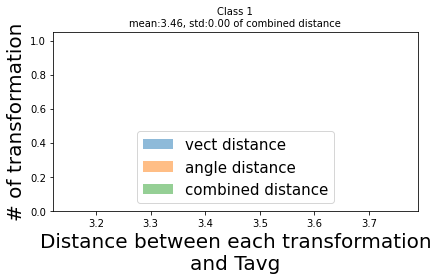

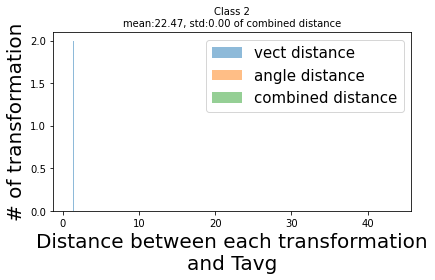

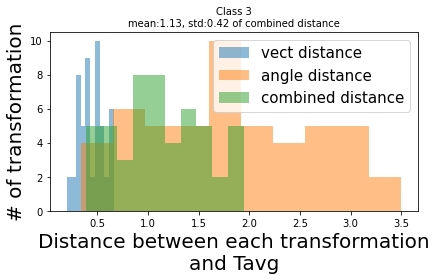

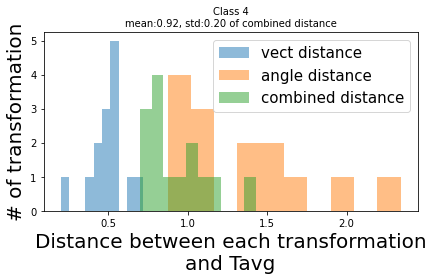

In [37]:
%matplotlib inline
polysome1.analyseTransFromPopulation()

In [38]:
# 14. link shorter polysomes
# Thissection is aimed to link shorter polysomes The idea is put one ribosome to the end
# of each poly to check if this filled up ribosome can link another polysome
# the functions to acheive this located at: ./polysome/py_mergePoly/tom_addTailRibo.py
# link_shortPoly located at: ./polysome/polysome_class
polysome1.fillPoly = { }
polysome1.fillPoly['class'] = np.array([-2]) #which class of trans want to link?(-2 for all classes)
polysome1.fillPoly['riboinfo'] = 1 #if print out the info of filled up ribos(0 to switch off)
polysome1.fillPoly['addNum'] = 1 #how many ribosomes added in the end of each polysome
polysome1.link_ShortPoly() #you can also try to add more than one hypo ribo at the end of each poly by pass  fillupRiboN = 2
#polysome1.analyseTransFromPopulation()

#the idea of polysome linking is like below:
#1. calculate the avgShift/avgRot of the trans from one class
#2. for each poly, add putative ribo
#3. calcluate the distance between putative ribo and another ribo fromm other polys
#4. check if the distance from 3 is within mean+2std of [min,max] of overall distance
#function to achieve 1 is located at:./polysome/py_summary/tom_analysePolysomePopulation.py
#function to achieve 2 is located at:./polysome/py_mergePoly/tom_extendPoly.py. ==> add one or more ribos at the end of each poly
#function to achieve 3 is located at:./polysome/py_mergePoly/tom_addTailRibo.py   ==> from line 238 to line 293
#function to achieve 4 is located at:./polysome/py_mergePoly/tom_addTailRibo.py   ==> from line 136 to line 139

<IPython.core.display.Javascript object>


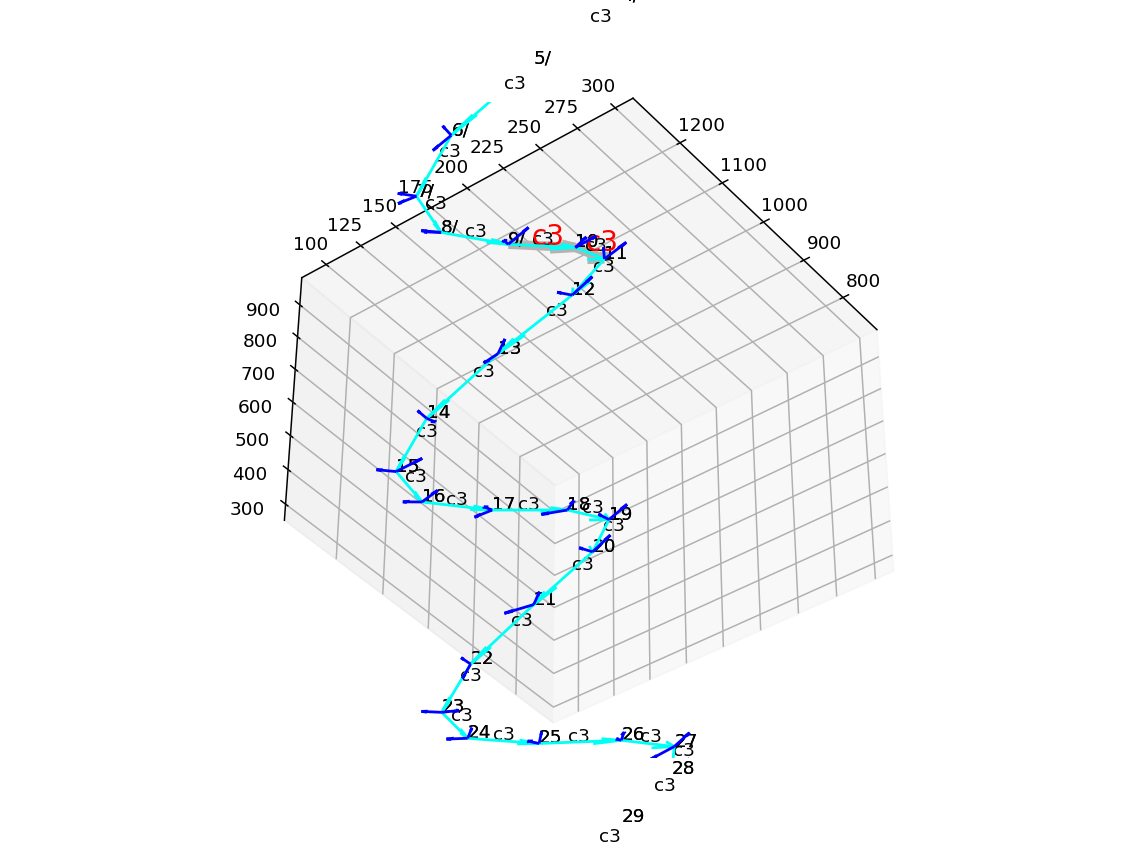

<IPython.core.display.Javascript object>


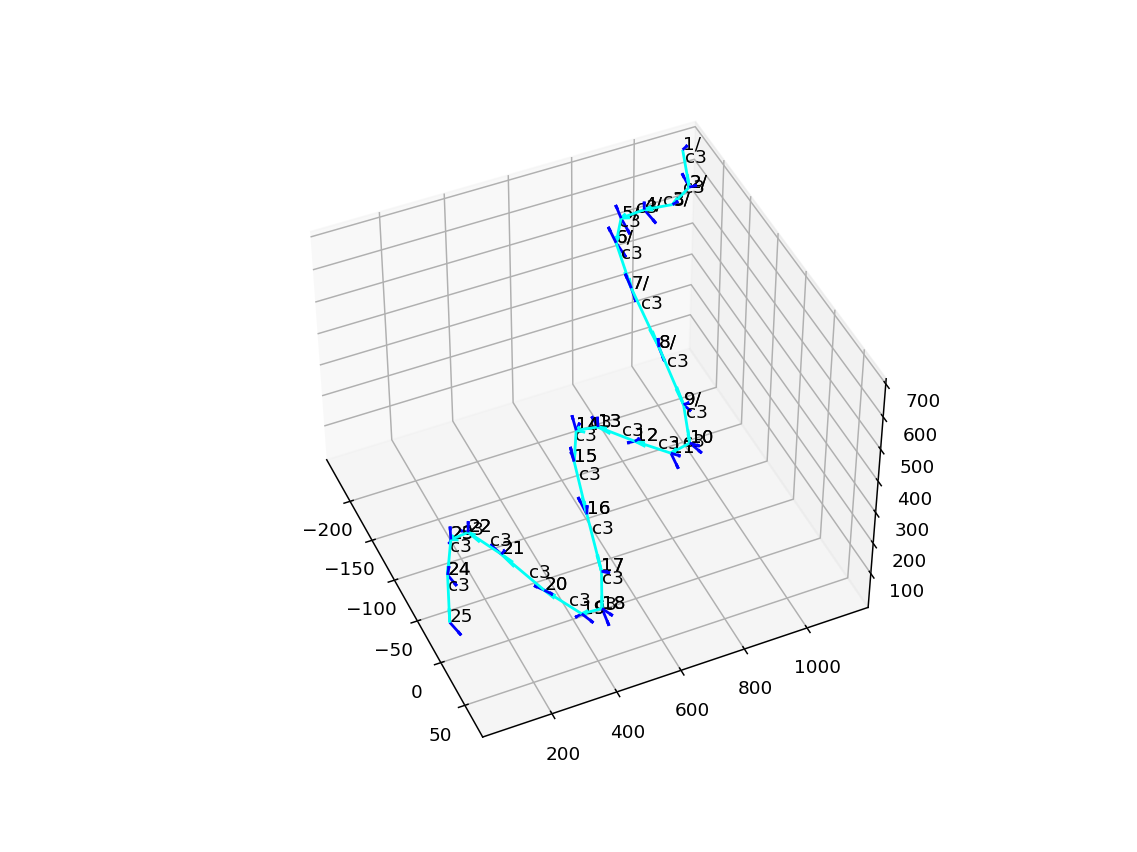

<IPython.core.display.Javascript object>


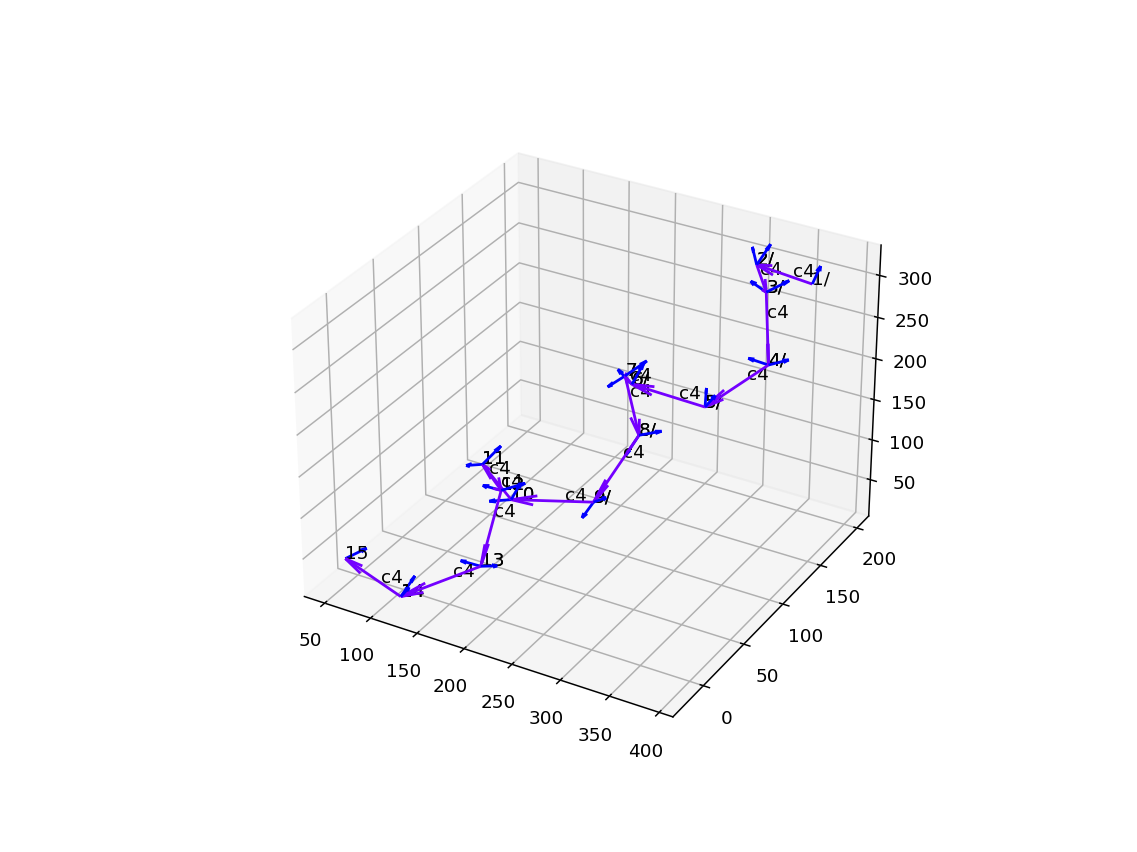

In [39]:
#14.1 after linking shorter polysomes, you can check it by vislize long polysomes.
#ATTENTION: Thosed filled up ribosomes should have grey color arrows pointing to OR arrows with grey border. And 
#those filled up ribosomes should have red labels 
%matplotlib notebook
polysome1.visPoly(lenPoly = 5)

In [40]:
#to check the new filled up ribosomes at the end of sim.star file.
from py_test.addRmPoly import teardown
teardown() #clean the data 